In [8]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input, decode_predictions
from keras.models import Model
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from keras.optimizers import Adam
from keras.metrics import Precision, Recall, Accuracy, F1Score
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model

In [9]:
train_path = "MacacosDataset/MacacosDataset-20231108T211111Z-001/MacacosDataset/training"
val_path = "MacacosDataset/MacacosDataset-20231108T211111Z-001/MacacosDataset/validation"
test_path = "MacacosDataset/MacacosDataset-20231108T211111Z-001/MacacosDataset/test"

batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255.
)

test_datagen = ImageDataGenerator(
    rescale = 1./255.
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (224, 224),
    batch_size = batch_size,
    class_mode = "categorical",
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    val_path,
    target_size = (224, 224),
    batch_size = batch_size,
    class_mode = "categorical",
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size = (224, 224),
    batch_size = batch_size,
    class_mode = "categorical"
)

train_num = train_generator.samples
validation_num = validation_generator.samples

for image, label in train_generator:
    print(image.shape)
    print(label.shape)
    break

Found 1098 images belonging to 10 classes.
Found 252 images belonging to 10 classes.
Found 30 images belonging to 10 classes.
(32, 224, 224, 3)
(32, 10)


In [15]:
base = VGG16(weights = 'imagenet',
             include_top = False,
             input_shape = (224, 224, 3),
             classes = 10
)
base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
base.trainable = False

model_vgg16 = Sequential()
model_vgg16.add(base)
model_vgg16.add(Flatten())
model_vgg16.add(Dense(128, activation = "relu"))
model_vgg16.add(Dense(10, activation = "softmax"))

model_vgg16.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               3211392   
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 17927370 (68.39 MB)
Trainable params: 3212682 (12.26 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [17]:
model_vgg16.compile(
    loss = CategoricalCrossentropy(),
    optimizer = Adam(),
    metrics = ['accuracy']
)

In [18]:
epochs = 40

filepath = ("Weights/vgg16weights.h5")

callbacks_list = [
    ModelCheckpoint(
        filepath,
        monitor = "val_accuracy",
        verbose = 1,
        save_best_only = True,
        mode = 'max'
    )
]

history = model_vgg16.fit(
    train_generator,
    steps_per_epoch=train_num//batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_num//batch_size,
    callbacks = callbacks_list
)

Epoch 1/40
34/34 [==============================] - ETA: 0s - loss: 2.9040 - accuracy: 0.1764
Epoch 1: val_accuracy improved from -inf to 0.29911, saving model to Weights\vgg16weights.h5
34/34 [==============================] - 126s 4s/step - loss: 2.9040 - accuracy: 0.1764 - val_loss: 1.8942 - val_accuracy: 0.2991
Epoch 2/40


C:\Users\Public\Anaconda\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - ETA: 0s - loss: 1.8440 - accuracy: 0.3415
Epoch 2: val_accuracy improved from 0.29911 to 0.42411, saving model to Weights\vgg16weights.h5
34/34 [==============================] - 119s 4s/step - loss: 1.8440 - accuracy: 0.3415 - val_loss: 1.5554 - val_accuracy: 0.4241
Epoch 3/40
34/34 [==============================] - ETA: 0s - loss: 1.6601 - accuracy: 0.4268
Epoch 3: val_accuracy improved from 0.42411 to 0.54911, saving model to Weights\vgg16weights.h5
34/34 [==============================] - 126s 4s/step - loss: 1.6601 - accuracy: 0.4268 - val_loss: 1.3419 - val_accuracy: 0.5491
Epoch 4/40
34/34 [==============================] - ETA: 0s - loss: 1.4294 - accuracy: 0.5338
Epoch 4: val_accuracy improved from 0.54911 to 0.66071, saving model to Weights\vgg16weights.h5
34/34 [==============================] - 124s 4s/step - loss: 1.4294 - accuracy: 0.5338 - val_loss: 1.1723 - val_accuracy: 0.6607
Epoch 5/40
34/34 [==============================] -

<Figure size 640x480 with 0 Axes>

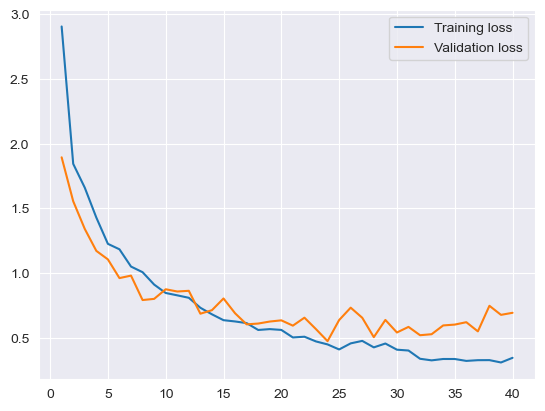

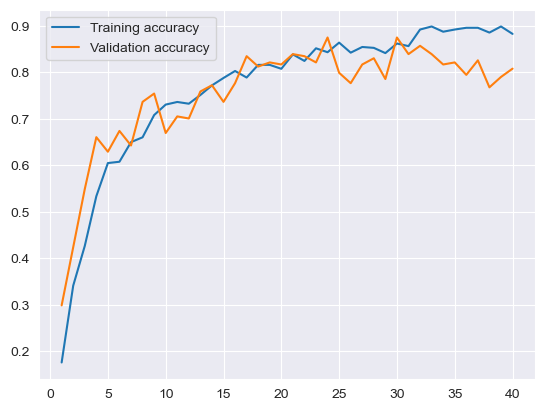

<Figure size 640x480 with 0 Axes>

In [19]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label = "Training loss")
plt.plot(epochs, val_loss, label = "Validation loss")
plt.legend()
plt.figure()

plt.plot(epochs, acc, label = "Training accuracy")
plt.plot(epochs, val_acc, label = "Validation accuracy")
plt.legend()
plt.figure()


1/1 [==============================] - 3s 3s/step


<Axes: >

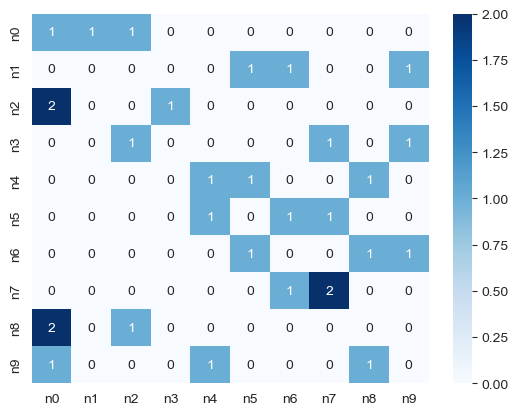

In [22]:
import seaborn as sns
from sklearn.utils.fixes import sklearn
from sklearn.metrics import confusion_matrix
threshold = 0.5
#model_ = load_model(filepath)
y_pred = (model_vgg16.predict(test_generator)>= threshold).astype(int)

y_pred = y_pred.argmax(axis=1)
y_real = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9])



confusion_matrix = confusion_matrix(y_real, y_pred)
labels =["n0", "n1", "n2", "n3", "n4", "n5", "n6", "n7", "n8", "n9"]
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, )